In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import csv
import datetime
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold,cross_val_score,KFold,StratifiedKFold
import pyprind
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = []
datetime_object = datetime.date.today()
print('datetime_object ',datetime_object)
data = pd.read_csv('dataSamples.csv')
data

datetime_object  2023-03-17


,label,image
0,một,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
1,xã,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
2,dự,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
3,nên,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
4,để,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
...,...,...
1495,với,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
1496,tư,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
1497,xử,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
1498,hà,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....


In [3]:
labels = []
images = []
labels = data.iloc[:,0].to_list()
images = data.iloc[:,-1].to_list()
print('\nThe number of data: ',len(labels))
max_str_len = max([len(label) for label in labels])
print('\nmax_str_len: ',max_str_len)


The number of data:  1500

max_str_len:  10


In [4]:
count = 0
for i, label in enumerate(labels):
    if type(label) == float:
        del labels[i]
        del images[i]
        count +=1
print('The number of invalid data: ',count)
print('The number of valid data left: ',len(labels))

The number of invalid data:  0
The number of valid data left:  1500


In [5]:
t = []
for i, image in enumerate(images):
    image = np.array(image.split(' '),dtype = float)
    t.append(image)
images = []

In [6]:
images = t
t = []
print('len images: ',len(images))

len images:  1500


In [7]:
images = np.array(images).reshape(-1,128,32,1)

# Split data to train_valid_test

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, train_size = .6, shuffle = True)

images = []
labels = []

In [9]:
X_train.shape

(900, 128, 32, 1)

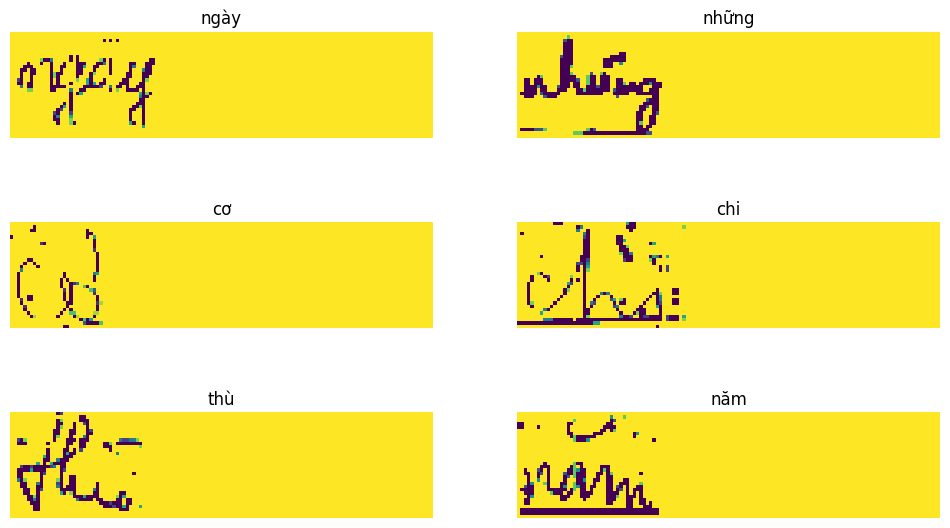

In [10]:
plt.figure(figsize = (12,7))
for i in range(6):
    rand = random.randint(0,len(X_train))
    plt.subplot(3,2,i+1)
    plt.title(y_train[rand])
    plt.imshow( np.rot90(np.fliplr(np.squeeze(X_train[rand,:,:,])))  )
    plt.axis('off')

# Prepare for CTC loss

In [11]:
alphabets = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÀÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƒƠơƯưạẢảẤấẦầẩẫậắằẳẵặẹẻẽếỀềỂểễỆệỉịọỏỐốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ'

print('The number of character: ',len(alphabets))
num_of_characters = len(alphabets)+1 #  +1 for CTC pseudo blank
num_of_timestamps = 31  # max length of predicted labels # Đặt num_of_timestamps <= shape(lastDenseModel)

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch==-1:  #CTC blank
            break
        else:
            ret +=alphabets[ch]
    return ret

The number of character:  147


In [12]:
train_y = np.ones([len(X_train), max_str_len]) * -1
train_label_len = np.zeros([len(X_train), 1])
train_input_len = np.ones([len(X_train),1]) * (num_of_timestamps - 2)
train_output = np.zeros([len(X_train)])

for i in range(len(X_train)):
    train_label_len[i] = len(y_train[i])
    train_y[i, 0:len(y_train[i])] = label_to_num(y_train[i])
print('len train_y ', len(train_y))

len train_y  900


In [13]:
valid_y = np.ones([len(X_valid), max_str_len]) * -1
valid_label_len = np.zeros([len(X_valid), 1])
valid_input_len = np.ones([len(X_valid), 1]) * (num_of_timestamps-2)
valid_output = np.zeros([len(X_valid)])

for i in range(len(X_valid)):
    valid_label_len[i] = len(y_valid[i])
    valid_y[i, 0:len(y_valid[i])]= label_to_num(y_valid[i])  
    
print ('len valid_y', len(valid_y))

len valid_y 600


In [14]:
train_y[0].shape #(11,)
train_label_len[0] # array([4.]) là nhãn của y_train[0] có 4 ký tự
train_input_len[0] # array([29.])
train_output.shape # (94123,) là array gồm 94123 ký tự 0
train_output #array([0., 0., 0., ..., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [15]:
print('\nTrue label_train  : ',y_train[10] , '\ntrain_y : ',train_y[10],'\ntrain_label_len : ',train_label_len[10], '\ntrain_input_len : ', train_input_len[10])


True label_train  :  Xe 
train_y :  [33. 39. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [2.] 
train_input_len :  [29.]


# Train model


In [16]:
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.callbacks import ModelCheckpoint

In [17]:
inputs = Input(shape=(128,32,1))
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same', name = 'conv1')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2, name = 'pool1')(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same',name = 'conv2')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, name = 'pool2')(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same',name = 'conv3')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same',name='conv4')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(1,2),name ='pool4')(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same',name = 'conv5')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization(name = 'Batchnormalization_1')(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same',name='conv6')(batch_norm_5)
batch_norm_6 = BatchNormalization(name='BatchNormalization_2')(conv_6)
pool_6 = MaxPool2D(pool_size=(1,2),name='pool6')(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu',name='conv7')(pool_6)

new_shape = (31,512)
squeezed = layers.Reshape(target_shape = new_shape, name = 'reshape')(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(alphabets)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [18]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 32, 64)       640       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 16, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 8, 128)        0         
                                                                 
 conv3 (Conv2D)              (None, 32, 8, 256)        295168    
                                                                 
 conv4 (Conv2D)              (None, 32, 8, 256)        590080

In [19]:
labels = layers.Input(name='gtruth_labels',shape = [max_str_len],dtype ='float32')
input_length = layers.Input(name = 'input_length',shape =[1],dtype='int64')
label_length = layers.Input(name='label_length',shape =[1],dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return tf.keras.backend.ctc_batch_cost(labels,y_pred,input_length,label_length)
loss_out = Lambda(ctc_lambda_func, output_shape = (1,), name = 'ctc')([outputs, labels, input_length, label_length])
model = Model(inputs = [inputs, labels, input_length, label_length], outputs = loss_out)

In [20]:
model.compile(loss = {'ctc': lambda y_true, y_pred:y_pred}, optimizer = keras.optimizers.Adam())
filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss',verbose=1, save_best_only = True,mode = 'auto')
callbacks_list = [checkpoint]

Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 40.7839
Epoch 00001: val_loss improved from inf to 18.58151, saving model to best_model.hdf5
9/9 [==============================] - 15s 501ms/step - loss: 40.7839 - val_loss: 18.5815
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 16.3838
Epoch 00002: val_loss improved from 18.58151 to 15.10412, saving model to best_model.hdf5
9/9 [==============================] - 3s 335ms/step - loss: 16.3838 - val_loss: 15.1041
Epoch 3/10
9/9 [==============================] - ETA: 0s - loss: 14.7086
Epoch 00003: val_loss improved from 15.10412 to 14.30191, saving model to best_model.hdf5
9/9 [==============================] - 3s 333ms/step - loss: 14.7086 - val_loss: 14.3019
Epoch 4/10
9/9 [==============================] - ETA: 0s - loss: 14.2392
Epoch 00004: val_loss improved from 14.30191 to 14.10244, saving model to best_model.hdf5
9/9 [==============================] - 3s 333ms/step - loss: 14.2392 - val_loss: 

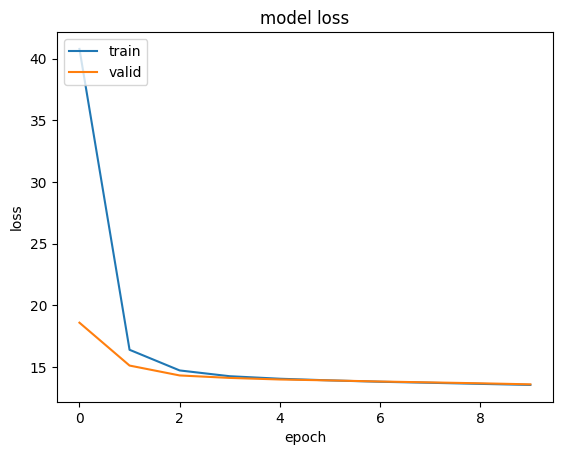

In [21]:
history = model.fit(x = [X_train,train_y, train_input_len, train_label_len], y = train_output,
         validation_data = ([X_valid,valid_y,valid_input_len, valid_label_len],valid_output),
         epochs = 10,
         batch_size = 100,
         callbacks = callbacks_list )

print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./model_word/word_model_{}_loss.png'.format(datetime_object))
plt.show()

In [22]:
# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(X_valid)
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

In [23]:
i = 0
for x in out:
    print("original_text =  ", y_valid[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

original_text =   Tân
predicted text = 

original_text =   đến
predicted text = 

original_text =   phiên
predicted text = 

original_text =   Nguyễn
predicted text = 

original_text =   các
predicted text = 

original_text =   bên
predicted text = 

original_text =   nhất
predicted text = 

original_text =   công
predicted text = 

original_text =   vừa
predicted text = 

original_text =   cá
predicted text = 

original_text =   chiến
predicted text = 

original_text =   nhiệt
predicted text = 

original_text =   trình
predicted text = 

original_text =   đi
predicted text = 

original_text =   ngày
predicted text = 

original_text =   số
predicted text = 

original_text =   chính
predicted text = 

original_text =   Tối
predicted text = 

original_text =   xác
predicted text = 

original_text =   tặc
predicted text = 

original_text =   biết
predicted text = 

original_text =   gồm
predicted text = 

original_text =   trí
predicted text = 

original_text =   đình
predicted text = 

o

In [24]:
X_valid[0].reshape(128,32)

array([[ 0.,  0.,  0., ...,  0., -5.,  0.],
       [ 0.,  0.,  0., ...,  0., -5.,  0.],
       [ 0.,  0.,  0., ...,  0., -5.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

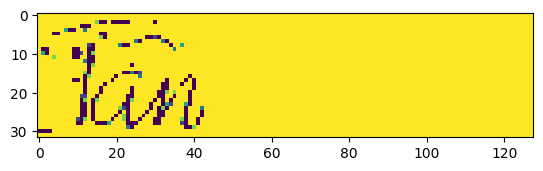

In [25]:
plt.imshow( np.rot90(np.fliplr(X_valid[0].reshape(128,32)))  )

In [26]:
preds = act_model.predict(X_valid)
#print('\n preds',preds)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])
#print ('\n decoded',decoded)
prediction = []
for i in range(len(X_valid)):
    prediction.append(num_to_label(decoded[i]))
    
decoded

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int64)